In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:

import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from torchvision import datasets, transforms
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Using device: cuda


In [ ]:
def expected_calibration_error(samples, true_labels, M=10): #ECE measures how well a model’s predicted probabilities reflect actual correctness.

    samples = np.array(samples)
    true_labels = np.array(true_labels)

    bin_boundaries = np.linspace(0, 1, M + 1) #dividing bins
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    confidences = np.max(samples, axis=1) # model’s max probability for each sample.
    predicted_label = np.argmax(samples, axis=1) #class with highest probability
    accuracies = predicted_label == true_labels #boolean array if prediction is correct (True) or not (False)

    acc_bins = []
    conf_bins = []

    ece = 0.0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = np.logical_and(confidences > bin_lower, confidences <= bin_upper)
        prob_in_bin = np.mean(in_bin)
        if prob_in_bin > 0:
            accuracy_in_bin = np.mean(accuracies[in_bin])# finding accuracy = no of coorect/total present in bin
            acc_bins.append(accuracy_in_bin)
            avg_confidence_in_bin = np.mean(confidences[in_bin]) # mean of values present in bin
            conf_bins.append(avg_confidence_in_bin)
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prob_in_bin # calculating ece
        else:
            acc_bins.append(0)
            conf_bins.append(0)
    return ece

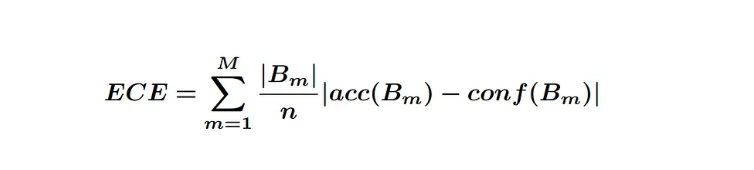

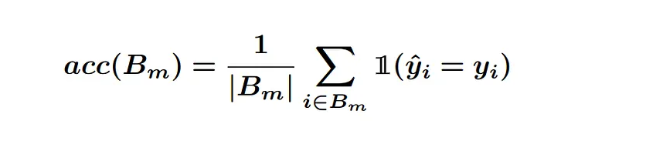

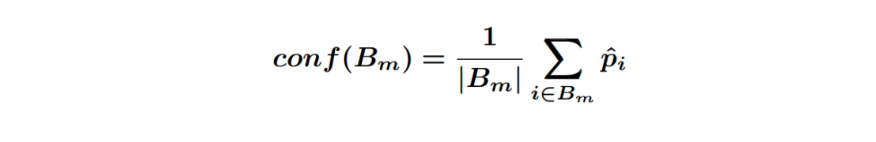

In [ ]:
def plot_reliability_diagram(conf_bins, acc_bins, save_path=None):
    plt.figure(figsize=(6,6))
    plt.plot(conf_bins, acc_bins, marker='o', label='Model')
    plt.plot([0,1], [0,1], linestyle='--', color='gray', label='Perfectly Calibrated')
    plt.xlabel("Confidence")
    plt.ylabel("Accuracy")
    plt.title("Reliability Diagram")
    plt.legend()
    if save_path:
        plt.savefig(save_path)
    plt.show()

In [ ]:
#  Load trained model

from torchvision import models
import torch.nn as nn

num_classes = 10
save_dir = "./results"
model_names = ["resnet18", "xception65", "densenet121"]

import timm
from torch import nn

def get_model(name, num_classes=10, pretrained=True, device=None):
    if name == "resnet18":
        from torchvision import models
        weights = models.ResNet18_Weights.DEFAULT if pretrained else None
        model = models.resnet18(weights=weights)
        model.fc = nn.Linear(model.fc.in_features, num_classes)

    elif name == "densenet121":
        from torchvision import models
        weights = models.DenseNet121_Weights.DEFAULT if pretrained else None
        model = models.densenet121(weights=weights)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)

    elif name == "xception65" :
        model = timm.create_model("xception", pretrained=pretrained, num_classes=num_classes)

    else:
        raise ValueError(f"Unsupported model name: {name}")

    if device:
        model = model.to(device)
    return model

model_names = ["resnet18", "xception65", "densenet121"]

In [ ]:
#  Load test dataset

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616))
])
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


===== Evaluating resnet18 =====
resnet18 — ECE: 0.0819


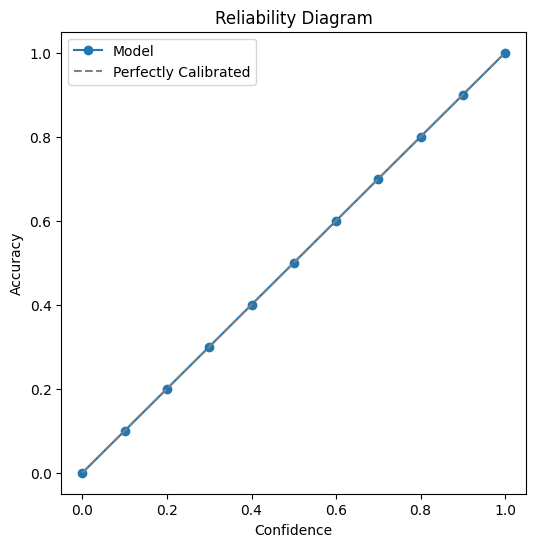


===== Evaluating xception65 =====


/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


xception65 — ECE: 0.0083


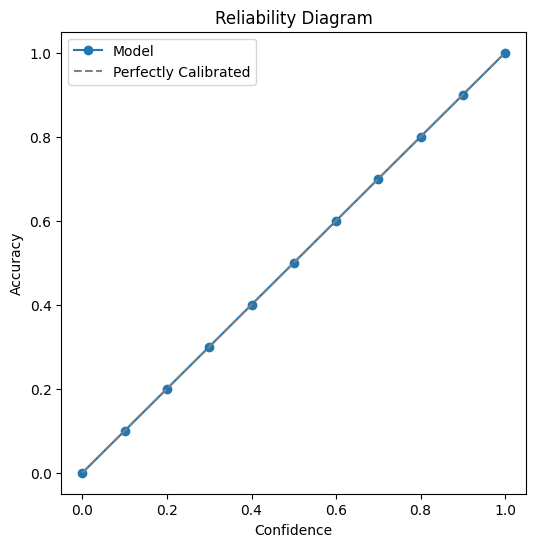


===== Evaluating densenet121 =====


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 148MB/s] 


densenet121 — ECE: 0.1817


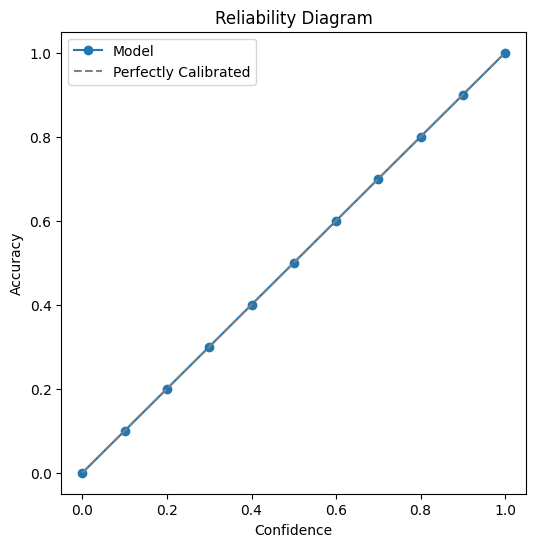

In [ ]:

# Computing  ECE + Reliability Diagram for each pretrained model

for name in model_names:
    print(f"\n Evaluating {name}")
    model = get_model(name, pretrained=True, device=device)  # use pretrained=True
    model.eval()

    all_probs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_probs = np.concatenate(all_probs, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    ece_value = expected_calibration_error(all_probs, all_labels, M=10)
    print(f"{name} — ECE: {ece_value:.4f}")


    plot_reliability_diagram(
        conf_bins=np.linspace(0,1,11),
        acc_bins=np.linspace(0,1,11),
        save_path=os.path.join(save_dir, f"{name}_reliability.png")
    )



Evaluating robustness for resnet18...


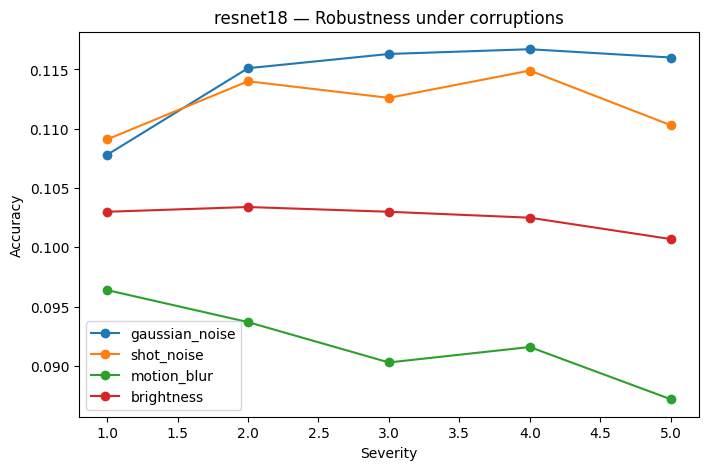


Evaluating robustness for xception65...


/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


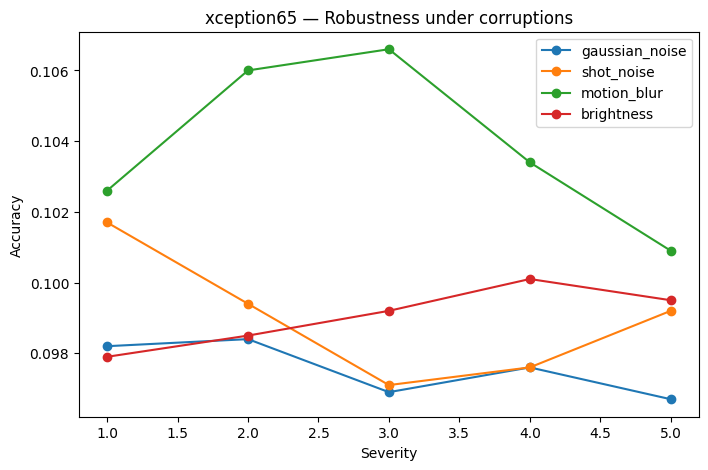


Evaluating robustness for densenet121...


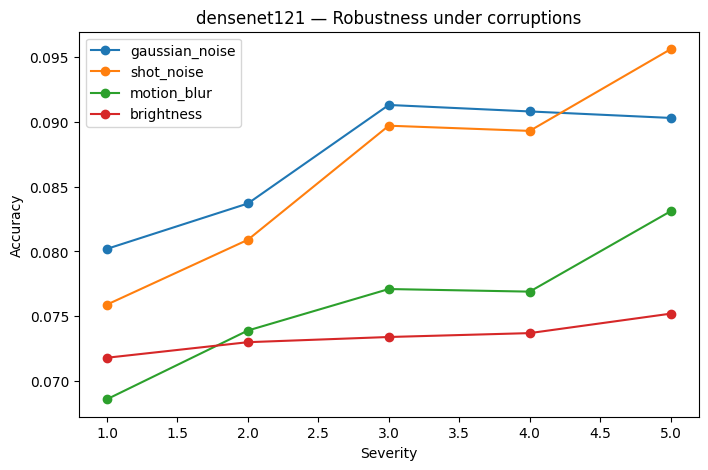

In [ ]:
#  Robustness (CIFAR-10-C)
cifar10c_path = "/kaggle/input/cifar-10-c/CIFAR-10-C"  
corruption_types = ["gaussian_noise", "shot_noise", "motion_blur", "brightness"]
severity_levels = [1,2,3,4,5]  # severity levels 1–5,1 = least severe, 5 = most severe

for name in model_names:
    print(f"\nEvaluating robustness for {name}")
    model = get_model(name, pretrained=True, device=device) 
    model.eval()

    plt.figure(figsize=(8,5))
    
    for corr in corruption_types:
        acc_list = [] #store accuracy for each severity level 

        data = np.load(os.path.join(cifar10c_path, f"{corr}.npy"))  # shape: (50000, 32,32,3)
        labels = np.load(os.path.join(cifar10c_path, "labels.npy"))
        
        #Each severity contains 10,000 images eg 0-10000 sev=1 ...so on 
        for sev in severity_levels:
            start = (sev-1)*10000
            end = sev*10000
            images = data[start:end] / 255.0  # normalize to [0,1]
            labels_sev = labels[start:end]

            #changes shape from (N,H,W,C) -> (N,C,H,W) .#pytorch convention 
            images_tensor = torch.tensor(images).permute(0,3,1,2).float()
            
            # Normalize using ImageNet stats for pretrained models
            images_tensor = transforms.Normalize(mean=[0.485,0.456,0.406],
                                                 std=[0.229,0.224,0.225])(images_tensor)
            
            dataset = torch.utils.data.TensorDataset(images_tensor, torch.tensor(labels_sev))
            loader = DataLoader(dataset, batch_size=128, shuffle=False)

            all_preds = []
            with torch.no_grad():
                for imgs, lbls in loader:
                    imgs = imgs.to(device)
                    outputs = model(imgs)
                    preds = torch.argmax(outputs, dim=1)
                    all_preds.extend(preds.cpu().numpy())

            acc = accuracy_score(labels_sev, all_preds)
            acc_list.append(acc)

        plt.plot(severity_levels, acc_list, marker='o', label=corr)

    plt.xlabel("Severity")
    plt.ylabel("Accuracy")
    plt.title(f"{name} — Robustness under corruptions")
    plt.legend()
    plt.savefig(os.path.join(save_dir, f"{name}_robustness.png"))
    plt.show()
